This notebook illustrates how to simulate simple transfer functions using 
1. scipy signal toolbox
2. control toolbox
2. manual implementation of ode45
3. state space representation

In [5]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import control

## Simulate Simple ODE
Let's simulate a simple ODE

$3*y' + 12y = 6u$

In [14]:
N = 100
dt = 2/100
T = np.linspace(0, 2, N)
U = np.zeros_like(T)
U[12:] = 1

def drawOutput(t,u,y,label='',title=''):
    plt.figure(figsize=(7,2))
    plt.plot(t,u,'b',label='u {}'.format(label))
    plt.plot(t,y,'r-',label='y {}'.format(label))
    plt.legend(loc='upper right')
    plt.title(title)
    plt.grid()
    

### scipy signal toolbox

#### As Trasnfer function representation

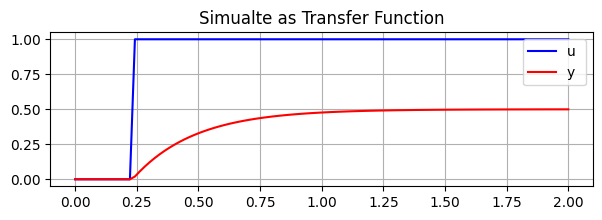

In [16]:
# Tranfer Function
num = [1]
den = [0.5,2]
sys1_tf = signal.TransferFunction(num,den)
t,y,x = signal.lsim(sys1_tf,U,T)
drawOutput(t,U,y,title='Simualte as Transfer Function')

#### in state space representation

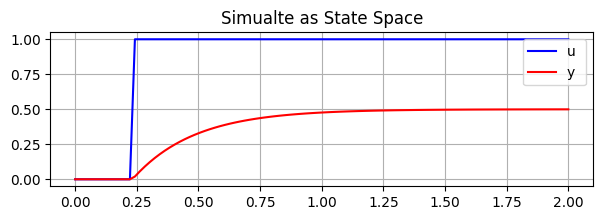

In [ ]:
#state space representation
A = -4.0; B = 2.0; C = 1.0; D = 0.0
sys1 = signal.StateSpace(A,B,C,D)
t,y,x = signal.lsim(sys1,U,T)
drawOutput(t,U,y,title='Simualte as State Space')

#### as discrete system

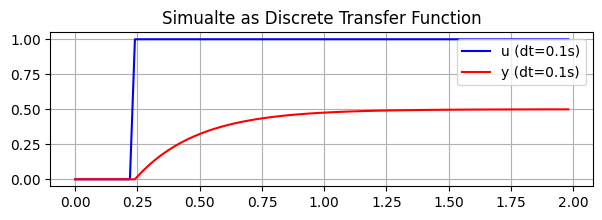

In [19]:
#discrete
sys1_tf_disc = sys1_tf.to_discrete(dt=dt)
t,y = signal.dlsim(sys1_tf_disc,U,)
drawOutput(t,U,y,label='(dt=0.1s)',title='Simualte as Discrete Transfer Function')

### Manually (using ode45)

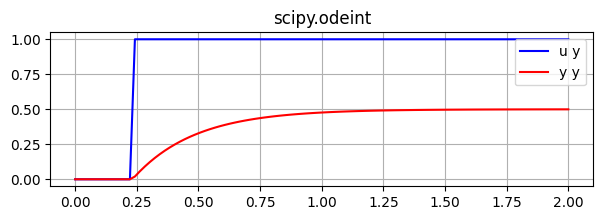

In [20]:
from scipy.integrate import odeint
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def fun(y, t, U):
    i = find_nearest_index(T,t)
    u = U[i]
    dydt = (6.0*u-12.0*y)/3.0
    return dydt
y0 = 0
y = odeint(fun, y0, T, args=(U,))
drawOutput(T,U,y,label='y',title='scipy.odeint')

#### 4th Order Runge-Kutta method

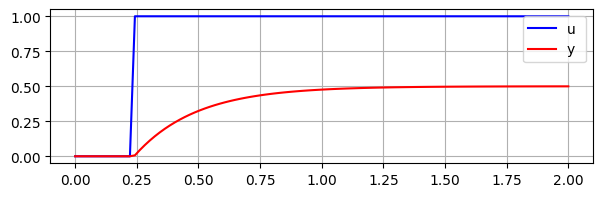

In [21]:
#4th Order Runge-Kutta method
import numpy as np
import matplotlib.pylab as plt

def ode45_step(f, x, t, dt, *args):
    """
    One step of 4th Order Runge-Kutta method
    """
    k = dt
    k1 = k * f(t, x, *args)
    k2 = k * f(t + 0.5*k, x + 0.5*k1, *args)
    k3 = k * f(t + 0.5*k, x + 0.5*k2, *args)
    k4 = k * f(t + dt, x + k3, *args)
    return x + 1/6. * (k1 + 2*k2 + 2*k3 + k4)

def ode45(f, t, x0, *args):
    """
    4th Order Runge-Kutta method
    """
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n-1):
        dt = t[i+1] - t[i] 
        x[i+1] = ode45_step(f, x[i], t[i], dt, *args)
    return x

y0 = [0]
y = ode45(lambda t,y,args: fun(y,t,args), T, y0, U)

drawOutput(T,U,y)

## Control Toolbox

/Users/jan/.pyenv/versions/diabetes-simulation/lib/python3.12/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_44739/3926636942.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(t,y,'r-',linestyle=style,label='y {}'.format(label))


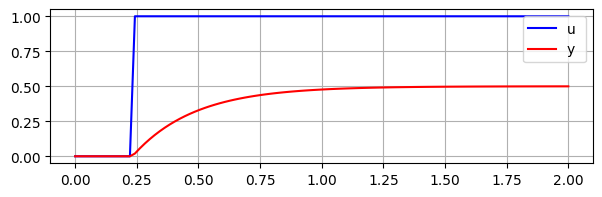

In [8]:
sys1 = control.tf(num,den)
t,y,x = control.forced_response(sys1,T,U,return_x=True)
drawOutput(t,U,y)

## Diabetes Model
Now, let's look at a more complex model using the Kirchsteiner diabetes model. Also, we stick to the control toolbox from now on.

### Define Model

In [26]:
def drawResults(t, y,input_iu,input_cho,fix_limits=True):
    plt.figure(figsize=(7,2))
    plt.plot(t,np.ones_like(t)*120,'--',color='lightgray')
    plt.plot(t,y,label='simulated glucose',color='b',linestyle=':',linewidth=3)
    
    if fix_limits:
        plt.ylim([-10,450])

    idxU = np.where(np.array(input_iu)>0)
    idxD = np.where(np.array(input_cho)>0)

    twinaxes = plt.gca().twinx()
    twinaxes.bar(t[idxU],input_iu[idxU],width=15,label='insulin (U)',color='blue',alpha=0.75)
    twinaxes.bar(t[idxD],input_cho[idxD]/10,width=15,label='carb units (10g)',color='orange',alpha=0.75)
    plt.legend(loc='upper left')

In [27]:
#define model
ISF = 40 #mg/dl/IU
CIR = 10#g CHO/IU
K1 = ISF/CIR #mg/dl/g CHO
K2 = -ISF
T1 = 30
T2 = 60

print(K1,K2)

duration_minutes = 24*60
T = np.arange(0,duration_minutes)

num1 = [K1]
den1 = [T1*T1,2*T1,1,0]
sys_carbs = control.tf(num1,den1)
num2 = [K2]
den2 = [T2*T2,2*T2,1,0]
sys_insulin = control.tf(num2,den2)

print('carbs subsystem')
print("K1={}, T1={}".format(K1,T1))
display(sys_carbs)

print('insulin subsystem')
print("K2={}, T2={}".format(K2,T2))
display(sys_insulin)

4.0 -40
carbs subsystem
K1=4.0, T1=30


TransferFunction(array([4.]), array([900,  60,   1,   0]))

insulin subsystem
K2=-40, T2=60


TransferFunction(array([-40]), array([3600,  120,    1,    0]))

### To LATEX

In [28]:
from sympy import symbols, Poly, latex, simplify
from sympy.abc import s
from IPython.display import display, Math

# Convert to sympy expressions
num_poly = Poly(np.array(sys_carbs.num).flatten(), s)
den_poly = Poly(np.array(sys_carbs.den).flatten(), s)
tf_expr = num_poly.as_expr() / den_poly.as_expr()
#tf_expr = simplify(tf_expr)

#print the transfer function expression
print(tf_expr)

# latex expression
tf_latex = latex(tf_expr)
print(tf_latex)

#display as formulat
display(Math(r"H(s) = " + tf_latex))

4.0/(900*s**3 + 60*s**2 + s)
\frac{4.0}{900 s^{3} + 60 s^{2} + s}


<IPython.core.display.Math object>

In [45]:
sys_carbs._repr_latex_()

'$$\\frac{4}{900 s^3 + 60 s^2 + s}$$'

### Test Signal

10g carbs and 1 unit of insulin should revert back to start.

/Users/jan/.pyenv/versions/diabetes-simulation/lib/python3.12/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


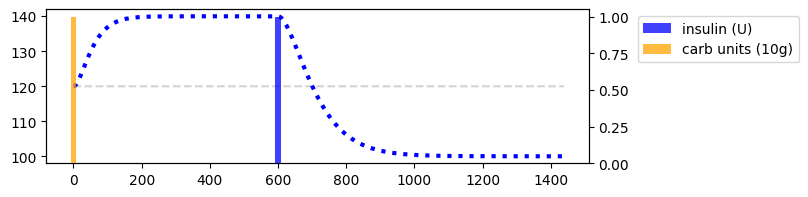

In [215]:
#10g carbs without bolus
u_carbs = np.zeros_like(T)
u_carbs[0]=10
#late correction bolus
u_insulin = np.zeros_like(T)
u_insulin[600] = 1

#simulate response
t,y_carbs,X = control.forced_response(sys_carbs, T, u_carbs, X0=0,return_x=True)
t,y_insulin,X = control.forced_response(sys_insulin, T, u_insulin, X0=0,return_x=True)
y = 120 + y_carbs + y_insulin

#draw 
drawResults(t, y, u_insulin, u_carbs,fix_limits=False)
plt.legend(loc='upper right',bbox_to_anchor=(1.4, 1.0))

The increase due to carbs is 20mg/dl but not 40mg/dl as expected. Why is that? Insulin looks fine.

#### Find Problem

Area under the curve for a value of 1 at t=0: 0.5
Area under the curve for a value of 1 at t=1: 1.0


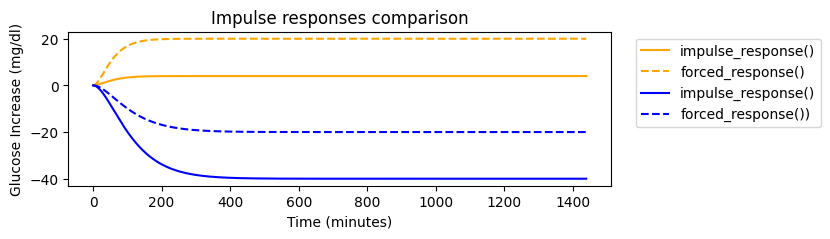

In [32]:
#carbs subsystem
u = np.zeros_like(T); u[0] = 10
t,y_cho_impulse = control.impulse_response(sys_carbs,T)
t,y_cho_forced = control.forced_response(sys_carbs, T, u)

#insulin subsystem
u = np.zeros_like(T); u[0] = 1
t,y_insulin_impulse = control.impulse_response(sys_insulin,T)
t,y_insulin_forced = control.forced_response(sys_insulin, T, u)

plt.figure(figsize=(7,2))
plt.plot(t,y_cho_impulse,label='impulse_response()',color='orange')
plt.plot(t,y_cho_forced,label='forced_response()',color='orange', linestyle='--')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Increase (mg/dl)')

#twinax = plt.twinx()
plt.plot(t,y_insulin_impulse,label='impulse_response()',color='blue')
plt.plot(t,y_insulin_forced,label='forced_response())',color='blue', linestyle='--')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0))
plt.title('Impulse responses comparison')


print('Area under the curve for a value of 1 at t=0: {}'.format(np.trapezoid([1,0,0],[1,2,3])))
print('Area under the curve for a value of 1 at t=1: {}'.format(np.trapezoid([0,1,0],[1,2,3])))

We see that the impulse response of the control toolbox does not match the manually simulated response using the forced_response function by a factor of 2. 
This is because the area of the impulse is 0.5 when using the trapezoid function. By adding the impulse to the second time point, it should work because then, the area is correctly calcualted as 1.

Let's repeat the experiment. This time adding the carbs and injections a little later.

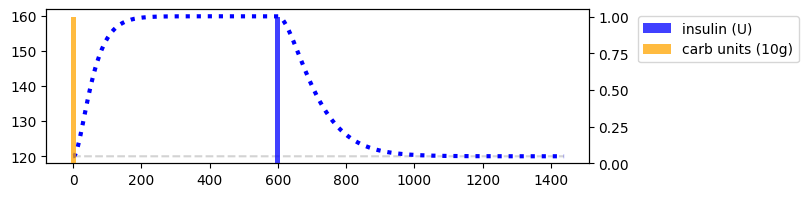

In [218]:
#re-simulate carbs but starting at 1 not 0
u_carbs = np.zeros_like(T)
u_carbs[1]=10 #that's the only difference with the previous simulation

t,y_carbs,X = control.forced_response(sys_carbs, T, u_carbs, X0=0,return_x=True)
y = 120 + y_carbs + y_insulin

drawResults(t, y, u_insulin, u_carbs,fix_limits=False)
plt.legend(loc='upper right',bbox_to_anchor=(1.4, 1.0))


### Typical Scenario

In [30]:
#define a scenario with meals and insulin injections
CHO = np.zeros_like(T)
IU = np.zeros_like(T)
CHO[[3*60, 8*60, 12*60, 18*60, 22*60]] = [80, 45, 60, 50, 20]
IU[[5*60, 9*60, 12*60, 18*60]] = [5, 5, 4, 8]

np.sum(CHO), np.sum(IU)

(np.int64(255), np.int64(22))

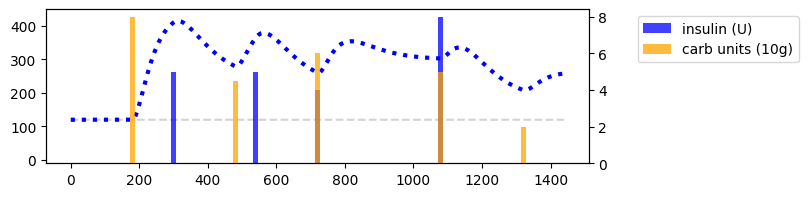

In [31]:
t,bg_delta_carbs = control.forced_response(sys_carbs,T,CHO,X0=0)
t,bg_delta_insulin = control.forced_response(sys_insulin,T,IU,X0=0)
Y = 120+bg_delta_insulin+bg_delta_carbs

drawResults(T,Y,IU,CHO)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0))

### Add convergence term (hi Lane :D)

add convergence to 120 baseline system


TransferFunction(array([-1]), array([1080,    1]))

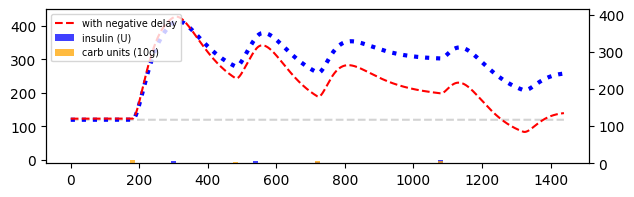

In [238]:
#add return to baseline
print('add convergence to 120 baseline system')
neg_delay = control.TransferFunction([-1],[18*60,1])
display(neg_delay)

#add convergence term
_,Y_neg_delay = control.forced_response(neg_delay,T,np.subtract(Y,120))
Y_WITH_CONVERGENCE = np.add(Y, Y_neg_delay)

drawResults(T,Y,IU,CHO)
plt.plot(T,Y_WITH_CONVERGENCE,label='with negative delay',color='r',linestyle='--')
plt.legend(fontsize='x-small',loc='upper left')

## Convert to State Space Form

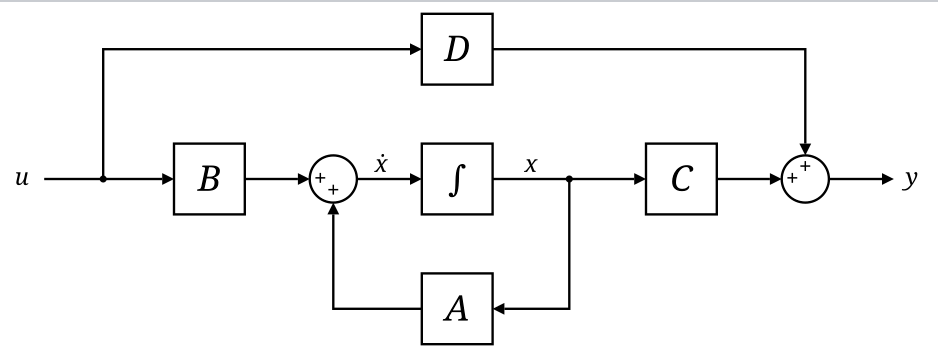
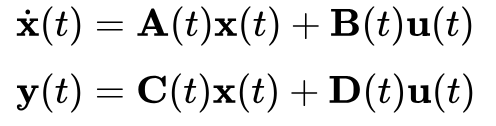

State space representation of the carbs system:


StateSpace(array([[-0.06666667, -0.00111111, -0.        ],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ]]), array([[1.],
       [0.],
       [0.]]), array([[0.        , 0.        , 0.00444444]]), array([[0.]]))

State space representation of the insulin system:


StateSpace(array([[-3.33333333e-02, -2.77777778e-04, -0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00]]), array([[1.],
       [0.],
       [0.]]), array([[ 0.        ,  0.        , -0.01111111]]), array([[0.]]))

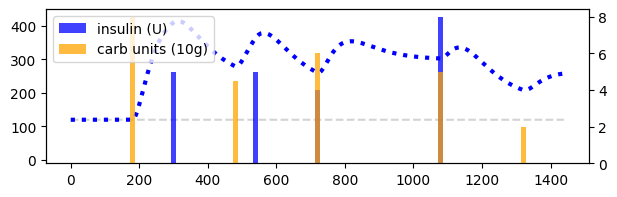

In [311]:
print('State space representation of the carbs system:')
ss_cho = control.tf2ss(sys_carbs)
display(ss_cho)

print('State space representation of the insulin system:')
ss_iu = control.tf2ss(sys_insulin)
display(ss_iu)


t,dbg_iu = control.forced_response(ss_iu,T,IU,X0=0)
t,dbg_cho = control.forced_response(ss_cho,T,CHO,X0=0)
drawResults(t,120+dbg_iu+dbg_cho,IU,CHO);


### manual state space matrix creation
(based on pen and paper calculation)

State space representation of the carbs system:


StateSpace(array([[ 0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        , -0.00111111, -0.06666667]]), array([[0.        ],
       [0.        ],
       [0.00444444]]), array([[1., 0., 0.]]), array([[0.]]))

State space representation of the insulin system:


StateSpace(array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00, -2.77777778e-04, -3.33333333e-02]]), array([[ 0.        ],
       [ 0.        ],
       [-0.01111111]]), array([[1., 0., 0.]]), array([[0.]]))

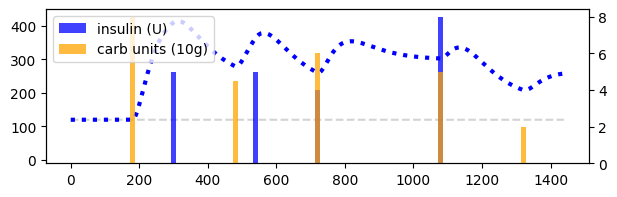

In [319]:
A_cho = np.matrix([[ 0,1,0],
        [0, 0, 1],
        [0,-1/(T1*T1), -2/T1]])
B_cho = np.matrix([[0],[ 0.],[ K1/(T1*T1)]])
A_iu = np.matrix([[ 0,1,0],
        [0,0,1],
        [0,-1/(T2*T2), -2/T2]])
B_iu = np.matrix([[0],[ 0.],[ K2/(T2*T2)]])
C = np.matrix([[ 1,0,0]])
D = np.matrix([[0]])

ss_cho_manual = control.StateSpace(A_cho,B_cho,C,D)

print('State space representation of the carbs system:')
display(ss_cho)


ss_iu = control.StateSpace(A_iu,B_iu,C,D)
print('State space representation of the insulin system:')
display(ss_iu)


t,dbg_iu = control.forced_response(ss_iu,T,IU,X0=0)
t,dbg_cho = control.forced_response(ss_cho,T,CHO,X0=0)
drawResults(t,120+dbg_iu+dbg_cho,IU,CHO);


### Manual Simulation

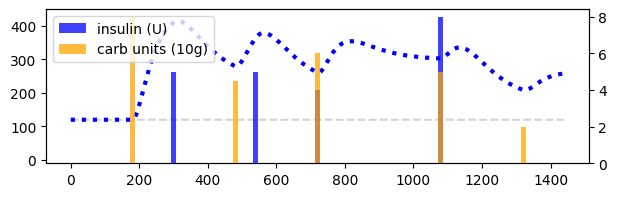

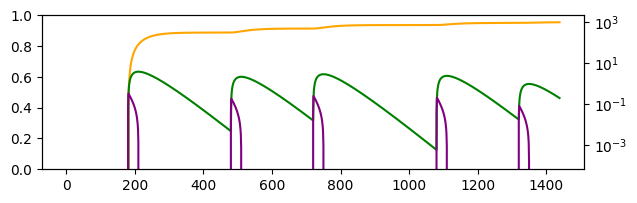

In [324]:
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def ode45_step(f, x, t, dt, *args):
    """
    One step of 4th Order Runge-Kutta method
    """
    k = dt
    k1 = k * f(t, x, *args)
    k2 = k * f(t + 0.5*k, x + 0.5*k1, *args)
    k3 = k * f(t + 0.5*k, x + 0.5*k2, *args)
    k4 = k * f(t + dt, x + k3, *args)
    return x + 1/6. * (k1 + 2*k2 + 2*k3 + k4)

def ode45(f, t, x0, *args):
    """
    4th Order Runge-Kutta method
    """
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n-1):
        dt = t[i+1] - t[i] 
        x[i+1] = ode45_step(f, x[i], t[i], dt, *args)
    return x

def fun(t,x, T, U, A, B):
    #get inputs
    i = find_nearest_index(T,t)
    x_mat = np.matrix(x).transpose() 
    dxdt = A*x_mat + B*U[i]
    return dxdt.flatten()

def ssOut(X,C):
    return C*X

x0 = [0,0,0];
X_CHO = ode45(fun, T, x0,   T, CHO, A_cho, B_cho)
Y_CHO = np.array([(C @ np.matrix(x).transpose()).item() for x in X_CHO])

x0 = [0,0,0];
X_IU = ode45(fun, T, x0, T,IU,A_iu,B_iu)
Y_IU = np.array([(C @ np.matrix(x).transpose()).item() for x in X_IU])

drawResults(T,120+Y_IU+Y_CHO,IU,CHO)

df = pd.DataFrame({'Time': T, 'Output': 120+Y_IU+Y_CHO, 'Input': IU, 'CHO': CHO, 'State1': X_CHO[:, 0], 'State2': X_CHO[:, 1], 'State3': X_CHO[:, 2]})

plt.figure(figsize=(7,2))
twinax = plt.twinx()
twinax.plot(T, df['State1'], label='State 1', color='orange')
twinax.plot(T,df['State2'], label='State 2', color='green')
twinax.plot(T,df['State3'], label='State 3', color='purple')
twinax.set_yscale('log')

## Comparing States

Here, just out of interest we compare the calcualtes states between the toolbox results and the manually calculated responses.

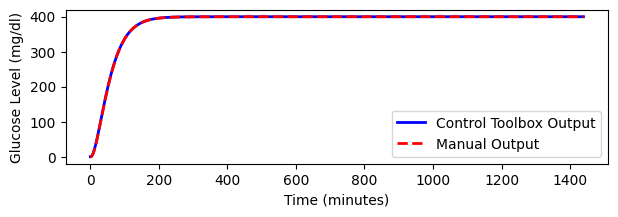

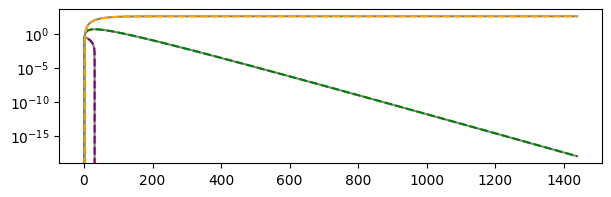

In [ ]:
cho_test = np.zeros_like(T)
cho_test[1]=100

#using control toolbox
t,y_control,x_control = control.forced_response(ss_cho, T, cho_test, X0=0, return_x=True)
df_control = pd.DataFrame({'Time': T, 'Output': y_control, 'Input': cho_test, 'State1': x_control[0,:], 'State2': x_control[1,:], 'State3': x_control[2,:]})

#using manual implementation
x_manual = ode45(fun, T, [0,0,0], T, cho_test, A_cho, B_cho)
y_manual = np.array([(C @ np.matrix(x).transpose()).item() for x in x_manual])
df_manual = pd.DataFrame({'Time': T, 'Output': y_manual, 'Input': cho_test, 'State1': x_manual[:, 0], 'State2': x_manual[:, 1], 'State3': x_manual[:, 2]})

#merge into one dataframe
df = pd.merge(df_control, df_manual, on='Time', suffixes=('_control', '_manual'))

#draw results for control toolbox and manual implementation
plt.figure(figsize=(7,2))
plt.plot(df['Time'], df['Output_control'], label='Control Toolbox Output', color='blue', linestyle='-',linewidth=2)
plt.plot(df['Time'], df['Output_manual'], label='Manual Output', color='red', linestyle='--', linewidth=2)
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Level (mg/dl)')
plt.legend()

#draw state variables
plt.figure(figsize=(7,2))
plt.plot(df['Time'], df['State3_control'], label='State 3 (Control)', color='gray', linestyle='-')
plt.plot(df['Time'], df['State3_manual'], label='State 3 (Manual)', color='purple', linestyle='--')
plt.plot(df['Time'], df['State2_control'], label='State 2 (Control)', color='gray', linestyle='-')
plt.plot(df['Time'], df['State2_manual'], label='State 2 (Manual)', color='green', linestyle='--')
plt.plot(df['Time'], df['State1_control'], label='State 1 (Control)', color='gray', linestyle='-')
plt.plot(df['Time'], df['State1_manual'], label='State 1 (Manual)', color='orange', linestyle='--')
plt.yscale('log')

Looks good, they overlap